# Vehicle detection: Yolo_Fastest
This example is referenced by Xilinx yolov3 example.
You can consult [DNNDK yolo example](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/tf_yolov3_voc_py/tf_yolov3_voc.py), [Vitis AI yolo example](https://github.com/Xilinx/Vitis-AI-Tutorials/blob/ML-at-Edge-yolov3/files/yolov3_voc.ipynb)

## 1. Prepare the overlay
We will download the overlay onto the board. Then we will load the 
corresponding DPU model.

In [18]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu4.bit")
overlay.load_model("dpu_yolo_fast_car.elf")

In [19]:
import numpy as np
import random
import cv2
import colorsys
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
%matplotlib inline
from pynq_dpu.edge.dnndk.tf_yolov3_voc_py.tf_yolov3_voc import *

### Constants

We will use the predefined anchors from K-means.

In [20]:
anchor_list = [13,18,19,26,28,40,43,39,53,63,83,104]
anchor_float = [float(x) for x in anchor_list]
anchors = np.array(anchor_float).reshape(-1, 2)

We will use the `get_class()` function in `tf_yolov3_voc` module to
get class names from predefined class names.

In [21]:
classes_path = "img/new_class.txt"
class_names = get_class(classes_path)

Depending on the number of classes, we will define a unique color for each
class.

In [22]:
num_classes = len(class_names)
hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: 
                  (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), 
                  colors))
random.seed(0)
random.shuffle(colors)
random.seed(None)

We can define some DPU-related parameters that come from the results of "VITIS_AI Compilation", such as DPU kernel name and
input/output node names.

In [23]:
KERNEL_CONV="yolo_fast_car"
CONV_INPUT_NODE="conv2d_Conv2D"
CONV_OUTPUT_NODE1="conv2d_58_Conv2D"
CONV_OUTPUT_NODE2="conv2d_53_Conv2D"

### Drawing bounding boxes
We now define a custom function that draws the bounding boxes around 
the identified objects after we have the classification results.

In [24]:
def draw_boxes(image, boxes, scores, classes):
    _, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_h, image_w, _ = image.shape

    for i, bbox in enumerate(boxes):
        [top, left, bottom, right] = bbox
        width, height = right - left, bottom - top
        center_x, center_y = left + width*0.5, top + height*0.5
        score, class_index = scores[i], classes[i]
        label = '{}: {:.4f}'.format(class_names[class_index], score) 
        color = tuple([color/255 for color in colors[class_index]])
        ax.add_patch(Rectangle((left, top), width, height,
                               edgecolor=color, facecolor='none'))
        ax.annotate(label, (center_x, center_y), color=color, weight='bold', 
                    fontsize=12, ha='center', va='center')
    return ax

### Predicting classes
We need to define a function that evaluates the scores and makes predictions
based on the provided class names.

In [25]:
def evaluate(yolo_outputs, image_shape, class_names, anchors):
    score_thresh = 0.2
    anchor_mask = [[3, 4, 5], [0, 1, 2]]
    boxes = []
    box_scores = []
    input_shape = np.shape(yolo_outputs[0])[1 : 3]
    input_shape = np.array(input_shape)*32

    for i in range(len(yolo_outputs)):
        _boxes, _box_scores = boxes_and_scores(
            yolo_outputs[i], anchors[anchor_mask[i]], len(class_names), 
            input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = np.concatenate(boxes, axis = 0)
    box_scores = np.concatenate(box_scores, axis = 0)

    mask = box_scores >= score_thresh
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(len(class_names)):
        class_boxes_np = boxes[mask[:, c]]
        class_box_scores_np = box_scores[:, c]
        class_box_scores_np = class_box_scores_np[mask[:, c]]
        nms_index_np = nms_boxes(class_boxes_np, class_box_scores_np) 
        class_boxes_np = class_boxes_np[nms_index_np]
        class_box_scores_np = class_box_scores_np[nms_index_np]
        classes_np = np.ones_like(class_box_scores_np, dtype = np.int32) * c
        boxes_.append(class_boxes_np)
        scores_.append(class_box_scores_np)
        classes_.append(classes_np)
    boxes_ = np.concatenate(boxes_, axis = 0)
    scores_ = np.concatenate(scores_, axis = 0)
    classes_ = np.concatenate(classes_, axis = 0)

    return boxes_, scores_, classes_

### Original picture
Let's also have a look at the original picture.

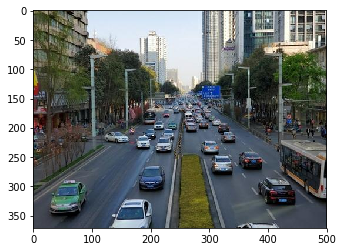

In [26]:
image_path = "img/2.jpg"
image = cv2.imread(image_path)
_, ax = plt.subplots(1)
_ = ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

The following cell will normalize the input picture size.

In [27]:
image_size = image.shape[:2]
image_data = np.array(pre_process(image, (320, 320)), dtype=np.float32)

## 3. Run application

We create DPU kernel and task.

In [11]:
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_CONV)
task = n2cube.dpuCreateTask(kernel, 0)

Now we execute the DPU task to classify an input picture.

In [49]:
import time
start = time.time()
input_len = n2cube.dpuGetInputTensorSize(task, CONV_INPUT_NODE)
n2cube.dpuSetInputTensorInHWCFP32(
    task, CONV_INPUT_NODE, image_data, input_len)

n2cube.dpuRunTask(task)

conv_sbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE1)
conv_out1 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE1, 
                                               conv_sbbox_size)
conv_out1 = np.reshape(conv_out1, (1, 10, 10, 18))

conv_mbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE2)
conv_out2 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE2, 
                                               conv_mbbox_size)
conv_out2 = np.reshape(conv_out2, (1, 20, 20, 18))

yolo_outputs = [conv_out1, conv_out2]    
stop = time.time()
a = stop - start
print(a)

0.026277780532836914


We can call the `evaluate()` function defined previously now. Depending on
how many objects can be identified in the picture, the function returns
a list of bounding box coordinates, a list of probability scores, and a list
of class indexes.

In [38]:
start = time.time()
boxes, scores, classes = evaluate(yolo_outputs, image_size, 
                                  class_names, anchors)
stop = time.time()
a = stop - start
print(a)

0.010880231857299805


Once we have all the bounding boxes, classes, and scores, we can feed them to
the `draw_boxes()` function to draw the bounding boxes over each recognized object.

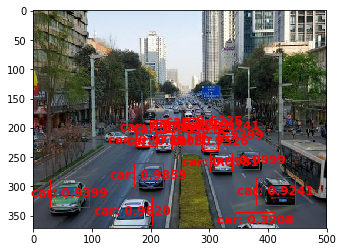

In [39]:
_ = draw_boxes(image, boxes, scores, classes)

Remember to clean up when you are done.

In [10]:
from pynq.lib import AxiGPIO
led_instance = overlay.ip_dict['axi_gpio_0']
led = AxiGPIO(led_instance).channel2

In [13]:
led[0].write(0x0)

In [15]:
led[0].write(0x1)

In [19]:
hd_gpio=overlay.axi_gpio_0.Output( parent=overlay.axi_gpio_0.channel1, 
                                            start=0, stop=1 )

In [22]:
hd_gpio.toggle()

In [2]:
from time import sleep
from pynq import Overlay
from pynq.lib import AxiGPIO

In [3]:
hd_gpio = overlay.axi_gpio_0.Output( parent=overlay.axi_gpio_0.channel1, start=0, stop=1 )

In [7]:
hd_gpio.toggle()

In [15]:
n2cube.dpuDestroyTask(task)
n2cube.dpuDestroyKernel(kernel)

0